# Histograms, Gradient Boosted Trees, Group-By Queries and One-Hot Encoding
We start with some imports.

In [1]:
import duckdb                    # v0.5.1
import matplotlib.pyplot as plt  # v.3.6.1
from matplotlib.ticker import MultipleLocator
import numpy as np               # v1.23.4
import pandas as pd              # v1.5.0
import pyarrow as pa             # v9.0.0
import tabmat                    # v3.1.2

from sklearn.ensemble._hist_gradient_boosting.histogram import (
    _build_histogram_root,
)                                # v1.1.2
from sklearn.ensemble._hist_gradient_boosting.common import (
    HISTOGRAM_DTYPE
)

## Naive visualisation of histograms

In [2]:
def highlight(df):
    if df["bin"] == 0:
        return ["background-color: rgb(255, 128, 128)"] * len(df)
    elif df["bin"] == 1:
        return ["background-color: rgb(128, 255, 128)"] * len(df)
    else:
        return ['background-color: rgb(128, 128, 255)'] * len(df)

df = pd.DataFrame({"bin": [0, 2, 1, 0, 1], "hessian": [1.5, 1, 2, 2.5, 3]})
df.style.apply(highlight, axis=1)

,bin,hessian
0,0,1.500000
1,2,1.000000
2,1,2.000000
3,0,2.500000
4,1,3.000000


In [3]:
# df.style.apply(highlight, axis=1).to_html()

Text(0.5, 1.0, 'Histogram')

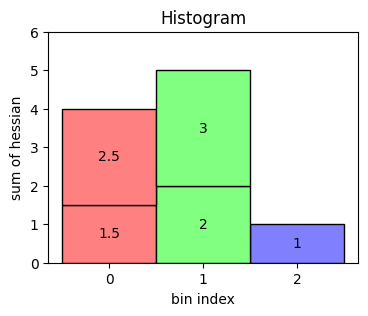

In [4]:
fig, ax = plt.subplots(figsize=(4, 3))
hist = np.zeros(df["bin"].max() + 1)
old_hist = hist.copy()
for i in range(len(df)):
    old_hist = hist.copy()
    hist[df.loc[i, "bin"]] += df.loc[i, "hessian"]
    if df.loc[i, "bin"] == 0:
        color = (1, 0.5, 0.5)
    elif df.loc[i, "bin"] == 1:
        color = (0.5, 1, 0.5)
    else:
        color = (0.5, 0.5, 1)
    p = ax.bar(
        x = [df.loc[i, "bin"]],
        height=hist[df.loc[i, "bin"]] - old_hist[df.loc[i, "bin"]],
        width=1,
        bottom=old_hist[df.loc[i, "bin"]],
        color=color,
        edgecolor="black",
    )
    ax.bar_label(p, label_type='center')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylim([0, 6])
ax.set_xlabel("bin index")
ax.set_ylabel("sum of hessian")
ax.set_title("Histogram")

## Using dedicated histogram method

We simulate `n_obs` data points and a single feature that is already binned: `binned_feature`.
Instead of observations `y`, gradient boosted trees have `gradients` and `hessians`.

In [2]:
rng = np.random.default_rng(42)
n_obs = 1000_000
n_bins = 256
binned_feature = rng.integers(0, n_bins, size=n_obs, dtype=np.uint8)
gradients = rng.normal(size=n_obs).astype(np.float32)
hessians = rng.lognormal(size=n_obs).astype(np.float32)

Now, we use the scikit-learn histogram method.

In [4]:
hist_root = np.zeros((1, n_bins), dtype=HISTOGRAM_DTYPE)
%time _build_histogram_root(0, binned_feature, gradients, hessians, hist_root)

CPU times: user 1.56 ms, sys: 1e+03 ns, total: 1.56 ms
Wall time: 1.57 ms


We observe that this is pretty fast. Keep im mind that this operation is executed many times when training gradient boosted trees with histograms: for each feature and for earch tree split for each boosting round.

Let's have a look at the results of the first 5 bins. The first column is the summed gradients, the second column the summed hessians and the last column is the count of observations.

In [5]:
hist_root[:, 0:5]

array([[(-79.72386998, 6508.89500265, 3894),
        ( 37.98393589, 6460.63222205, 3998),
        ( 53.54256977, 6492.22722797, 3805),
        ( 21.19542398, 6797.34159299, 3928),
        ( 16.24716742, 6327.03757573, 3875)]],
      dtype=[('sum_gradients', '<f8'), ('sum_hessians', '<f8'), ('count', '<u4')])

Let't plot the histograms. Note that gradients can be both positive and negative. We randomly generated the gradients and hessians and this in reflected in the histograms: We see a lot of noise.

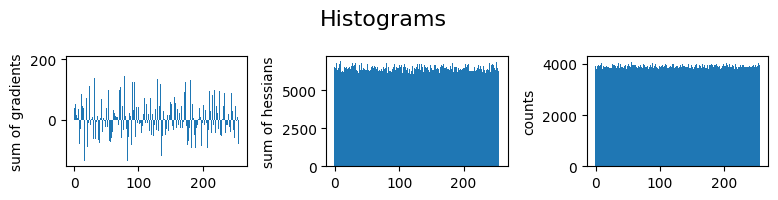

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2))
axes[0].stairs(hist_root["sum_gradients"].squeeze(), np.arange(n_bins+1)-0.5, fill=True)
axes[0].set_ylabel("sum of gradients")
axes[1].stairs(hist_root["sum_hessians"].squeeze(), np.arange(n_bins+1)-0.5, fill=True)
axes[1].set_ylabel("sum of hessians")
axes[2].stairs(hist_root["count"].squeeze(), np.arange(n_bins+1)-0.5, fill=True)
axes[2].set_ylabel("counts")
fig.suptitle("Histograms", fontsize=16)
fig.tight_layout()

## Using SQL Group By Query
This whole operation looks like a simple group-by query. We use duckdb as our query engine. Instead of pandas, we use pyarrow to create a table which duckdb can operate on natively.

In [5]:
con = duckdb.connect()
arrow_table = pa.Table.from_pydict(
    {
        "bin": binned_feature,
        "gradients": gradients,
        "hessians": hessians,
})
# Read data once to make timing fairer
arrow_result = con.execute("SELECT * FROM arrow_table")

In [6]:
%%time
arrow_result = con.execute("""
SELECT
    bin as bin,
    SUM(gradients) as sum_gradients,
    SUM(hessians) as sum_hessians,
    COUNT() as count
FROM arrow_table
GROUP BY bin
""").arrow()

CPU times: user 23 ms, sys: 3.57 ms, total: 26.5 ms
Wall time: 6.52 ms


Altough this is pretty fast, it is still slower than the dedicated routine.

Again, let's look at the result. This time, wee need to sort by bin in order to compare to previous results.

In [7]:
arrow_result.sort_by("bin").slice(length=5)

pyarrow.Table
bin: uint8
sum_gradients: double
sum_hessians: double
count: int64
----
bin: [[0,1,2,3,4]]
sum_gradients: [[-79.72386997545254,37.98393589106854,53.54256977112527,21.195423980039777,16.247167424764484]]
sum_hessians: [[6508.895002648234,6460.632222048938,6492.227227974683,6797.341592986137,6327.037575732917]]
count: [[3894,3998,3805,3928,3875]]

We are relieved to obtain the exact same result for the first 5 rows. Interestingly, this group-by query can also be directly computed with Arrow itself.

In [8]:
%%time
arrow_result = arrow_table.group_by("bin").aggregate(
    [
        ("gradients", "sum"),
        ("hessians", "sum"),
        ("bin", "count"),
    ]
)

CPU times: user 10.3 ms, sys: 2.09 ms, total: 12.4 ms
Wall time: 10.8 ms


In [9]:
arrow_result.sort_by("bin").slice(length=5)

pyarrow.Table
gradients_sum: double
hessians_sum: double
bin_count: int64
bin: uint8
----
gradients_sum: [[-79.72386997545254,37.98393589106854,53.54256977112527,21.195423980039777,16.247167424764484]]
hessians_sum: [[6508.895002648234,6460.632222048938,6492.227227974683,6797.341592986137,6327.037575732917]]
bin_count: [[3894,3998,3805,3928,3875]]
bin: [[0,1,2,3,4]]

## One-Hot encoded matrix
Quite interestingly, this filling up a histogram with given bin indices can be represented as a matrix multiplication.
The trick is to treat `binned_feature` as a categorical feature and use its one-hot encoded representation `m_OHE`.
As `binned_feature` already contains the (bin) indices, we can use a further nump trick to cunstruct the `m_OHE`.

In [10]:
%%time
m_OHE = np.eye(n_bins)[binned_feature].T
vec = np.column_stack((gradients, hessians, np.ones_like(gradients)))

CPU times: user 359 ms, sys: 410 ms, total: 769 ms
Wall time: 770 ms


In [11]:
%%time
result_ohe = m_OHE @ vec

CPU times: user 749 ms, sys: 14.7 ms, total: 763 ms
Wall time: 199 ms


In [12]:
result_ohe[:5]

array([[ -79.72386998, 6508.89500265, 3894.        ],
       [  37.98393589, 6460.63222205, 3998.        ],
       [  53.54256977, 6492.22722797, 3805.        ],
       [  21.19542398, 6797.34159299, 3928.        ],
       [  16.24716742, 6327.03757573, 3875.        ]])

This is again the same result, but unfortunately much slower and taking much more memory.
Both can be improved to some extend with the helpt of tabmat.

In [13]:
%time m_categorical = tabmat.CategoricalMatrix(cat_vec=binned_feature)

CPU times: user 56.1 ms, sys: 22.1 ms, total: 78.3 ms
Wall time: 21.5 ms


In [14]:
# tabmat needs contigous arrays with dtype = Python float = float64
vec = np.asfortranarray(vec, dtype=float)

In [15]:
%%time
tabmat_result = np.column_stack(
    (
        vec[:, 0] @ m_categorical,
        vec[:, 1] @ m_categorical,
        vec[:, 2] @ m_categorical,
    )
)

CPU times: user 22.4 ms, sys: 3.73 ms, total: 26.2 ms
Wall time: 4.82 ms


In [16]:
tabmat_result[0:5]

array([[ -79.72386998, 6508.89500265, 3894.        ],
       [  37.98393589, 6460.63222205, 3998.        ],
       [  53.54256977, 6492.22722797, 3805.        ],
       [  21.19542398, 6797.34159299, 3928.        ],
       [  16.24716742, 6327.03757573, 3875.        ]])

While the timing of this approach is quite good, the construction of `CategoricalMatrix` requires quite some time.

In the end, the special (Cython) routine wins the timing. The different approaches connect some quite different domains and show how connected algorithms can be.